Refine the tasks obtained using literature mining with GPT-4

In [3]:
import json
import fasttext
import os
from ontology_learner.json_utils import parse_jsonl_file
from pathlib import Path
import contextlib
import io
import re
import nltk
from nltk.corpus import stopwords
import umap
import numpy as np

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))


datadir = Path('/Users/poldrack/Dropbox/data/ontology-learner/data')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/poldrack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def parse_jsonl_task_line(line):
    """Parses a single line of JSONL into a dictionary."""
    json_data = json.loads(line.strip())

    content = json_data['response']['body']['choices'][0]['message']['content']
    # clean up content
    content = content.replace("```json", "").replace("```", "")
    content_dict = json.loads(content)
    assert content_dict['type'] != 'other', f"type is other for {json_data['custom_id']}"
    content_dict['type'] = content_dict['type'].replace('task-', '')
    content_dict['type'] = content_dict['type'].replace('_', ' ')
    content_dict['description'] = ''.join(content_dict['description'])
    content_dict['model'] = json_data['response']['body']['model']
    content_dict['custom_id'] = json_data['custom_id'].replace('task-','').replace('/','_')
    content_dict['system_fingerprint'] = json_data['response']['body']['system_fingerprint']
    return content_dict



In [5]:
task_jsonl = list((datadir / 'task_results').glob('batch*.jsonl'))[0]

# context manager to suppress print statements
with contextlib.redirect_stdout(io.StringIO()) as f:
    tasks = list(parse_jsonl_file(task_jsonl, parse_jsonl_task_line))
print(f'Loaded {len(tasks)} tasks from {task_jsonl}')

task_dict = {}
for t in tasks:
    
# %%


Loaded 7495 tasks from /Users/poldrack/Dropbox/data/ontology-learner/data/task_results/batch_673a22e948a48190ad4e60083569448e.jsonl


In [6]:
# seriallize each task structure to a string
# after removing the following keys from the dictionary: 'type', 'system_fingerprint', 'model'
task_strings = {}
english_stopwords.update(['description', 'references',
                     'conditions', 'disorders', 'custom_id'])
for t in tasks:
    t_dict = t.copy()
    for k in ['type', 'system_fingerprint', 'model']:
        t_dict.pop(k)
    dictstr = json.dumps(t_dict)
    # remove punctuation
    dictstr = re.sub(r'[^\w\s]', '', dictstr)
    dictstr = dictstr.lower().replace('_', ' ')
    # remove one letter words
    dictstr = re.sub(r'\b\w\b', '', dictstr)
    # remove <> tags
    dictstr = re.sub(r'<[^>]*>', '', dictstr)
    # remove stopwords
    dictstr = ' '.join([word for word in dictstr.split() if word not in english_stopwords])
    task_strings[t['custom_id']] = dictstr

# %%

task_string_file = datadir / 'task_results' / 'task_strings.txt'
with open(task_string_file, 'w') as f:
    for s in task_strings.values():
        f.write(s + '\n')

# %%

Learn embedding using fasttext

In [7]:
model = fasttext.train_unsupervised(task_string_file.as_posix(), dim=100)

Read 0M words
Number of words:  10603
Number of labels: 0
Progress: 100.0% words/sec/thread:  139246 lr:  0.000000 avg.loss:  1.885459 ETA:   0h 0m 0s


In [8]:
embeddings = {}
for k, v in task_strings.items():
    embeddings[k] = model.get_word_vector(v)

# %%


### Cluster tasks to find similar ones

First perform agglomerative clustering to identify sets.

In [22]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5)
cluster.fit(list(embeddings.values()))
print(f'Found {len(set(cluster.labels_))} clusters')
# %%

Found 1402 clusters


In [23]:
# create a dictionary mapping each cluster to a list of task ids
cluster_dict = {}
cluster_embeddings = {}
task_keys = list(embeddings.keys())

for i, l in enumerate(cluster.labels_):
    if l not in cluster_dict:
        cluster_dict[l] = []
    cluster_dict[l].append(task_keys[i])
    # append the embedding to the cluster embedding
    if l not in cluster_embeddings:
        cluster_embeddings[l] = []
    cluster_embeddings[l].append(embeddings[task_keys[i]])
# %%

For each cluster, create a prompt that will ask the LLM to identify unique tasks within the set.

In [33]:
system_msg = """
You are an expert in psychology and neuroscience.
You should be as specific and as comprehensive as possible in your responses.
Your response should be a JSON object with no additional text.  
"""


def get_task_set_prompt(tasks):
    prompt = f"""
# CONTEXT #
Researchers in the field of cognitive neuroscience and psychology study specific 
psychological constructs, which are the building blocks of the mind, such as 
memory, attention, theory of mind, and so on.  To study them, researchers use 
experimental tasks or surveys, which are meant to measure behavior related to the 
constructs.  These are experiment measures in which an individual is presented with
stimuli and behavior is measured.  A measure is referred to as a "survey" if it involves
presenting specific questions to the participant and recording their self-reported responses. 
For example, the "Beck Depression Inventory" is a survey that measures depression.  
Any other kind of psychological measure that involves presenting stimuli and recording behavior
is referred to as a "task".  For example, the "go/no-go task" is a task that involves 
presenting stimuli and recording whether the participant makes a response or not on each trial.


# OBJECTIVE #
You will be provided with a list of task labels that were identified by a language model based on
publications.  Each set of labels may contain duplicate labels for the same task, and may also include acronyms 
for the task.  For example, for the stop signal task, there might be the following labels:

stop signal task
stop-signal task
stop signal task (SST)
stop-go task
Logan stop signal task

Your job is to group together all of the labels within the set that most likely refer to the same task, 
and also to identify any acroymns that are used for the task (such as SST in the previous example).  There may be multiple 
tasks within each set, and some may not have acroynms.

# DATA #

Here is the list of tasks to be clustered with a brief description of each:

{tasks}

# RESPONSE #
Please return the results in JSON format. 

The result should include a dictionary of dicts.   Each subdict should refer to a single task that was identified 
from the set, and its key should be a consensus name derived from the set.  For the example above, the consensus name would be 
"stop signal task".

Each subdict should include two keys:
- "labels": containing a list of labels that match this task
- "acronymns": containing a list of any acronyms that were identified, or an empty list of no acronyms were identified.

Respond only with JSON, without any additional text or description.
"""
    return prompt




In [41]:
def create_task_prompt(cluster_names, )
cluster_dict[13]

['edinburgh_handedness_inventory_questionnaire',
 'edinburgh_handedness_inventory_scale',
 "briggs-nebes_modified_version_of_annett's_handedness_inventory",
 'edinburgh_handedness_inventory_(ehi)',
 'edinburgh_handedness_inventory',
 'chapman_handedness_inventory',
 'self-assessed_handedness_questionnaire',
 'waterloo_handedness_questionnaire-revised_(whq-r)',
 'edinburgh_inventory',
 'flinders_handedness_survey_questionnaire']

In [12]:
# for each clsuter, find outliers
for k, v in cluster_dict.items():
    emb = np.array(cluster_embeddings[k])
    
# %%

In [19]:
from sklearn.cluster import HDBSCAN, mean_shift, estimate_bandwidth, AffinityPropagation
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import warnings

cluster_method = 'agglom' # 'outlier' # 'hdbscan' #

for cluster_num in cluster_dict.keys():
    # suppress warning
    X = np.array(cluster_embeddings[cluster_num])
    # scale X
    if X.shape[0] > 2:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            if cluster_method == 'hdbscan':
                X = StandardScaler().fit_transform(X)

                min_cluster_size = 2 
                clusterer = HDBSCAN(min_cluster_size=min_cluster_size, 
                                    metric='euclidean', cluster_selection_method='eom').fit(X)
            elif cluster_method == 'mean_shift':
                bandwidth = .2 # estimate_bandwidth(X, quantile=0.2, n_samples=500)
                clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=False).fit(X)
            elif cluster_method == 'AffinityPropagation':
                X = StandardScaler().fit_transform(X)
                clusterer = AffinityPropagation().fit(X)
            elif cluster_method == 'outlier':
                X = StandardScaler().fit_transform(X)
                thr = -0.1
                clusterer = LocalOutlierFactor(n_neighbors=4, contamination=0.1)
                outlier_labels = clusterer.fit_predict(X)
            elif cluster_method == 'agglom':
                X = StandardScaler().fit_transform(X)
                clusterer = AgglomerativeClustering(n_clusters=None, distance_threshold=0.4)

            labels = clusterer.fit_predict(X) if cluster_method != 'outlier' else outlier_labels
    else:
        # vector of ones 
        labels = X.shape[0] * [1]
    print(f'Cluster {cluster_num}: {len(set(labels))} subclusters')
    # print members of each subcluster
    labels = sorted(labels)
    for l in set(labels):
        for t in cluster_dict[cluster_num]:
            if labels[cluster_dict[cluster_num].index(t)] == l:
                print(f'l={l}:  {t}')

    print()
# %%
# %%

Cluster 162: 15 subclusters
l=0:  modified_navigation_task
l=1:  virtual_navigation_task
l=2:  cued_navigation_task
l=3:  treasure_hunt_task
l=4:  virtual_navigation
l=5:  virtual_reality_maze_task
l=6:  spatial_navigation_performance
l=7:  spatial_navigation_task
l=8:  navigation_task
l=9:  local_navigation_task
l=10:  navigation_pattern_task
l=11:  navigation_tasks
l=12:  virtual_spatial_navigation_task
l=13:  behavioral_tasks_involving_memory_and_spatial_processing
l=14:  virtual_reality_navigation_task

Cluster 1734: 4 subclusters
l=0:  go-no-go
l=1:  go_nogo
l=2:  go_no-go_impulse_task
l=3:  go-no-go_task

Cluster 301: 14 subclusters
l=0:  verbal_recognition_memory_(vrm)
l=1:  recognition_task
l=2:  recognition_memory_test
l=3:  old_new_recognition_test
l=4:  recognition_and_memory_task
l=5:  episodic_memory_recognition_task
l=6:  learning-recognition_task
l=7:  forced-choice_recognition_test
l=8:  memory_recognition_task
l=9:  recognition_memory_paradigm
l=10:  old-new_recognitio

In [20]:
np.unique(labels)

array([1])

In [15]:
# reduce dimensionality using UMAP
reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(list(embeddings.values()))

# %%


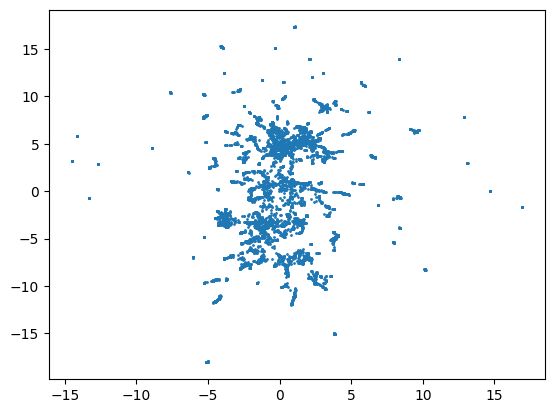

In [16]:
# plot using matplotlib
import matplotlib.pyplot as plt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)
plt.show()

# %%


In [42]:
tasks

[{'type': 'task',
  'description': 'The modified navigation task is a variety of spatial navigation task that typically involves manipulating various environmental or task variables to assess how participants encode, store, and retrieve spatial information. Participants might be asked to navigate a virtual or physical environment with alterations to test different cognitive and neural mechanisms underlying navigation.',
  'constructs': ['spatial memory',
   'cognitive flexibility',
   'spatial awareness'],
  'references': ['Astur, R. S., Taylor, L. B., Mamelak, A. N., Philpott, L., & Sutherland, R. J. (2002). Humans with hippocampus damage display severe spatial memory impairments in a virtual Morris water task. Behavioral Brain Research, 132(1), 77-84.',
   'Wolbers, T., & Hegarty, M. (2010). What determines our navigational abilities? Trends in Cognitive Sciences, 14(3), 138-146.'],
  'conditions': ['cue-based navigation',
   'landmark-based navigation',
   'route learning',
   'wayf